In [46]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
import pandas as pd

In [47]:
def degree(g, nodes=None, as_list=True):
    deg = None
    if nodes:
        deg = dict(g.degree(nodes))
    else:
        deg = dict(g.degree())
    
    if as_list:
        return list(deg.values())
    return deg

def degree_plot(g, nodes, title=''):
    deg = degree(g, nodes)
    bins = 100
    if len(nodes) < 100:
        bins = len(nodes)
    hist = np.histogram(deg, bins=bins)
    v = range(min(deg), max(deg)+1)
    freqs, edges = hist[0], hist[1]
    n = freqs.size
    means = [(edges[i] + edges[i+1]) / 2 for i in range(n)]
    
    # SCATTER PLOT
    plt.plot(means, freqs, ".")
    plt.xlabel("k")
    plt.ylabel("frequency")
    plt.title("Degree distribution for %s" % title)
    plt.show()
    
    # LOG LOG PLOT
    plt.loglog(means, freqs, ".")
    plt.xlabel("log(k)")
    plt.ylabel("log(frequency)")
    plt.title("Log-log degree distribution for %s" % title)
    plt.show()

In [84]:
USER = 'user'
ELITE_USER = 'elite_user'
BIZ = 'biz'

In [15]:
biz = pd.read_csv('toronto/toronto_biz.csv')
user = pd.read_csv('toronto/toronto_users.csv')
reviews = pd.read_csv('toronto/toronto_reviews.csv')
elite_user = user[~user.elite.str.contains('None')]

In [45]:
print('#Reviews:', len(reviews))
print('#Users:', len(set(reviews.user_id)))
print('#Elite users:', len(elite_user))
print('#Businesses:', len(set(reviews.business_id)))

#Reviews: 379875
#Users: 84624
#Elite users: 7499
#Businesses: 9678


### Creating the network

In [49]:
# A node class for storing data.
class Node:
    def __init__(self, Data, Type):
        self.Data = Data
        self.Type = Type
    
    def to_string(self):
        return "Node (%s), Data: " % (self.Type, self.Data)
    
    def __hash__(self):
        return hash(self.Data)
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.Data == other.Data
               )

In [88]:
elite_reviews.text = reviews[reviews.user_id.isin(elite_user.user_id)]

In [77]:
elite_ids = set(elite_user.user_id)

In [197]:
atleast2 = reviews.groupby('user_id').filter(lambda x: len(x) > 2)
len(set(atleast2.user_id))

27109

In [ ]:
G = nx.Graph()
for row in reviews.itertuples():
    a_type = ELITE_USER if row.user_id in elite_ids else USER
    a = Node(row.user_id, a_type)
    user_ids = reviews[reviews.business_id == row.business_id].user_id
    for uid in user_ids:
        b_type = ELITE_USER if uid in elite_ids else USER
        b = Node(uid, b_type)
        G.add_edge(a, b)

In [184]:
print('Nodes:', len(G.nodes()))
print('Edges:', len(G.edges()))

Nodes: 94291
Edges: 379875


### Degree Dist

In [102]:
biz_nodes = [n for n in list(G.nodes()) if n.Type == BIZ]
user_nodes = [n for n in list(G.nodes()) if n.Type == USER]
elite_user_nodes = [n for n in list(G.nodes()) if n.Type == ELITE_USER]

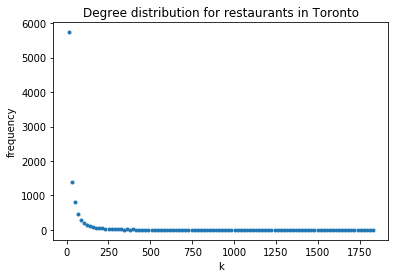

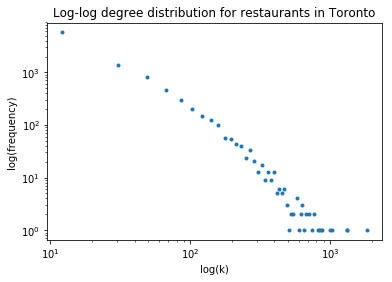

In [106]:
degree_plot(G, biz_nodes, "restaurants in Toronto")

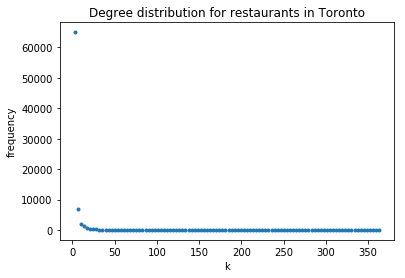

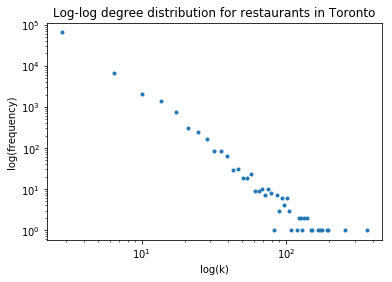

In [107]:
degree_plot(G, user_nodes, "restaurants in Toronto")

### Largest subcomponent

In [187]:
subgraphs = list(nx.connected_component_subgraphs(G))

In [192]:
[len(sg.nodes()) for sg in subgraphs]

[94246, 4, 4, 8, 4, 4, 5, 4, 4, 4, 4]

In [138]:
L = max(nx.connected_component_subgraphs(G), key=len)
print("Nodes in largest subcomponent:", len(L.nodes()))
print("Edges in largest subcomponent:", len(L.edges()))

Nodes in largest subcomponent: 94246
Edges in largest subcomponent: 379840


The graph is connected, and therefore the largest subcomponent is the graph itself.

### Eigenvector Centrality

In [140]:
ev_centrality = nx.eigenvector_centrality_numpy(G)
sorted_ev_centrality = sorted(ev_centrality.items(), key=lambda x: x[1], reverse=True)
ev_elite_user = [(x,y) for (x,y) in sorted_ev_centrality if x.Type == ELITE_USER]

### Degree Centrality

### Removing elite users

In [157]:
n = 20
number_elite_nodes = np.zeros(n)
number_elite_edges = np.zeros(n)

In [173]:
G1 = G.copy()

In [159]:
deg_centrality = nx.degree_centrality(G1)
sorted_deg_centrality = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)
elite_user_by_degree = [x for (x,y) in sorted_deg_centrality if x.Type == ELITE_USER]

In [170]:
one_percent = round(len(elite_user_by_degree) / 100)

In [175]:
for i in range(n):
    print("Start of round %i..." % (i+1))
    start, end = i * one_percent, (i+1) * one_percent
    nodes_to_remove = elite_user_by_degree[start:end]
    G1.remove_nodes_from(nodes_to_remove)
    subgraph = max(nx.connected_component_subgraphs(G1), key=len)
    number_elite_nodes[i] = len(subgraph.nodes())
    number_elite_edges[i] = len(subgraph.edges())

Start of round 1...
Start of round 2...
Start of round 3...
Start of round 4...
Start of round 5...
Start of round 6...
Start of round 7...
Start of round 8...
Start of round 9...
Start of round 10...
Start of round 11...
Start of round 12...
Start of round 13...
Start of round 14...
Start of round 15...
Start of round 16...
Start of round 17...
Start of round 18...
Start of round 19...
Start of round 20...


In [176]:
number_elite_nodes

array([94128., 94040., 93935., 93847., 93761., 93670., 93587., 93502.,
       93417., 93333., 93243., 93158., 93074., 92979., 92886., 92795.,
       92708., 92623., 92540., 92445.])

In [178]:
number_elite_edges

array([360142., 348549., 339397., 331801., 325222., 319450., 314252.,
       309438., 304975., 300827., 296992., 293429., 290120., 287030.,
       284142., 281415., 278845., 276408., 274084., 271879.])